In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import gc
import sys

## 1. load temperature data and add time features

In [6]:
# load temperature data from Tempelhofer Feld, Berlin, Germany in pandas(downloaded from www.ecad.eu)
folder_Data = "../../data/ECA_blended_custom(6)/"
with open(file=folder_Data + "TG_STAID002759.txt", mode = 'r') as file:
    df_raw = pd.read_csv(file, sep=',', header='infer', skiprows=19)

## 2. Impute data

In [7]:
# get rid of leading whitespaces in headers
df_raw.columns = ['SOUID', 'DATE', 'TG', 'Q_TG']

# Add the missing values by taking the mean of the temperature of the same day one year earlier and later
missing_value_mask = (df_raw['Q_TG'] == 9)
next_year_mask = (df_raw.loc[df_raw['Q_TG'] == 9].index + 365)
previous_year_mask = (df_raw.loc[df_raw['Q_TG'] == 9].index - 365)
df_raw['TG'].loc[missing_value_mask] = (df_raw['TG'].iloc[next_year_mask].values + df_raw['TG'].iloc[previous_year_mask].values) / 2

## 3. Feature engineering

### 3.1 create y-data

In [8]:
# create the timesteps
df_raw['timestep'] = list(range(df_raw.shape[0]))
# convert date to DATETIME
df_raw['DATETIME'] = pd.to_datetime(df_raw['DATE'],format="%Y%m%d")
# devide the temperature by 10
df_raw['TG'] = df_raw['TG'].apply(lambda x: x / 10)
# make the date as an index
df_raw.set_index('DATETIME', inplace=True)
y = df_raw.drop(columns=['SOUID', 'DATE', 'Q_TG', 'timestep'])
y.head(3)

,TG
DATETIME,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3


<AxesSubplot:xlabel='DATETIME'>

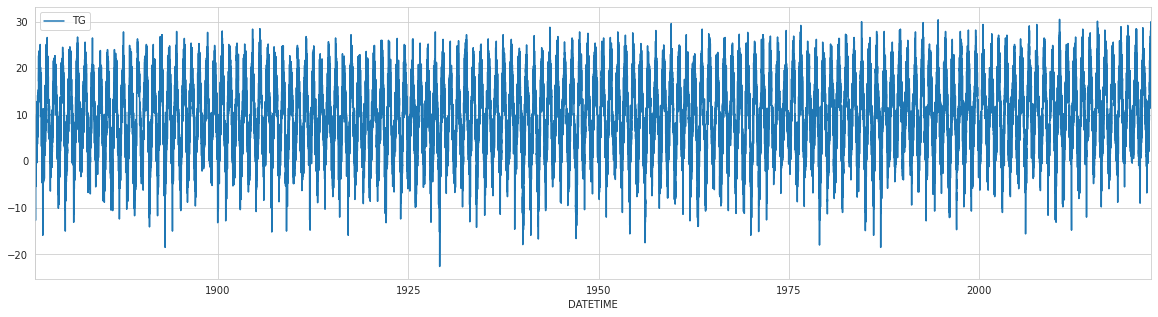

In [9]:
# plot the data
y.plot(figsize=(20,5),legend=True)

### 3.2 differenciate data to get the remainder

<AxesSubplot:xlabel='DATETIME'>

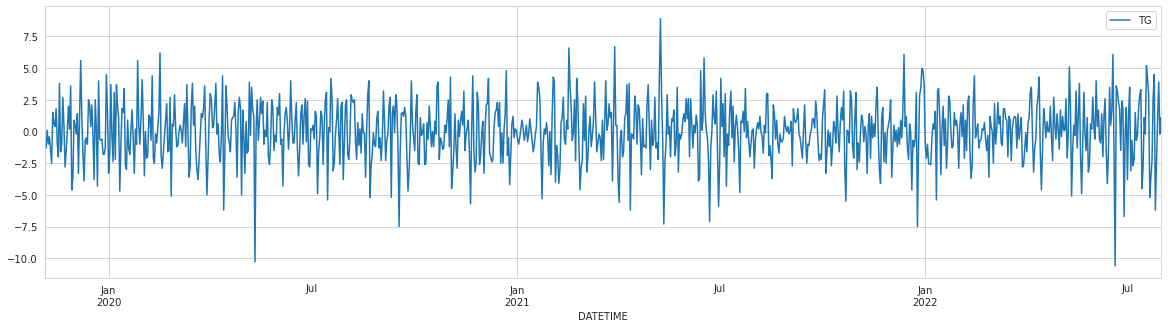

In [10]:
# deduct trend and saisonality by differencing by degree 1
y_diff = y.diff(1)
y_diff[-1000:].plot(figsize=(20,5),legend=True)

<AxesSubplot:xlabel='DATETIME'>

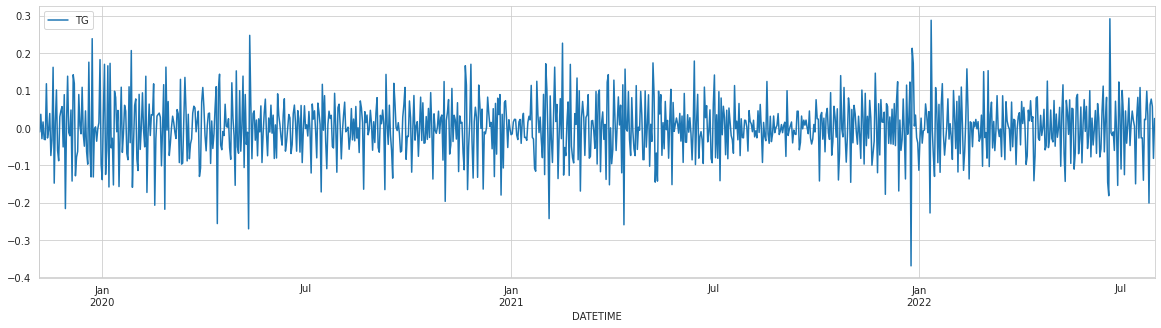

In [11]:
# create y_log with a differentiation of degree 2 
# (+30 in order to get only positive logs)
y_log = np.log(y + 30).diff(1).diff(1) 
y_log[-1000:].plot(figsize=(20,5),legend=True)

## 4. Create an AutoArima model and fit it

In [12]:
run_auto_arima = True
if run_auto_arima:
    arima = pm.AutoARIMA(
        m=365,              # seasonality cycle
        d=1,               # apply differences
        maxiter=100,
        seasonal=True,
        start_p=1, 
        start_q=1,
        max_p=3,
        max_q=3,
        stepwise=True,
        trace=True,
        test='adf' 
    )

In [13]:
# fit the autoarima model
# --> Runs out of memory when starting with the 2nd model
if run_auto_arima:
    y_arima = y[-365*3:]
    arima.fit(y_arima)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[365] intercept   : AIC=4888.683, Time=638.41 sec
 ARIMA(0,1,0)(0,0,0)[365] intercept   : AIC=4916.826, Time=0.16 sec


## 5. Create a manual ARIMA model

In [9]:
# define ARIMA model manually
y_arima = y[-365*3:]
arima_1 = ARIMA(y_arima, order=(1,1,1), seasonal_order=(0,0,0,365))
res_1 = arima_1.fit()
print(res_1.summary())

/home/thorsten/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/thorsten/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/thorsten/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                     TG   No. Observations:                 1095
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2438.696
Date:                Sat, 03 Sep 2022   AIC                           4883.392
Time:                        01:56:21   BIC                           4898.385
Sample:                    08-02-2019   HQIC                          4889.065
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4299      0.128     -3.370      0.001      -0.680      -0.180
ma.L1          0.5938      0.115      5.184      0.000       0.369       0.818
sigma2         5.0550      0.173     29.206      0.0

In [10]:
# attempt to clear the memory in order to fit another model --> FAILED
run_code = False
if run_code:
    print(sys.getsizeof(arima_1))
    del arima_1
    del res_1
    gc.collect()

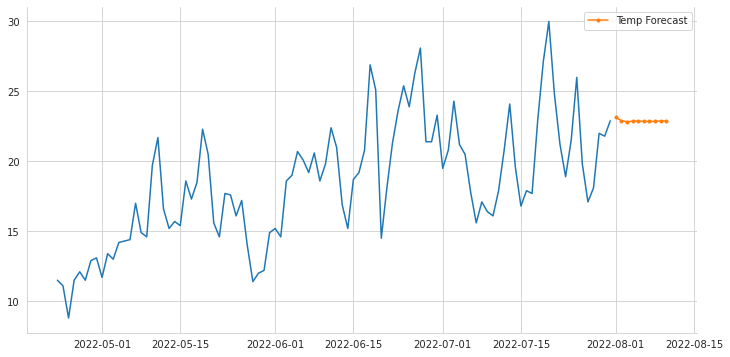

In [ ]:
# plot the prediction of the manual ARIMA model
y_forecast = res_1.predict(start='2022-08-01', end='2023-02-28')
# create some date values for the forecast horizon
index_vals = pd.date_range('2022-08-01', '2023-02-28', freq='D')
plt.figure(figsize=(12,6))
plt.plot(y_arima.index.values[-100:], y_arima.values[-100:])
# plt.fill_between(index_vals.values, ci[:,0], ci[:, 1], alpha=0.7, color='lightgrey', label='95% CI')
plt.plot(index_vals.values[:10], y_forecast[:10], label='Temp Forecast', marker='.')
sns.despine()
plt.legend()